<a href="https://colab.research.google.com/github/Simonsanchezs/ProyectoModelos2/blob/main/Proyecto_Modelos_2_Sebastian_Pelaez_Simon_Sanchez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import kagglehub

path = kagglehub.dataset_download("hrishitpatil/flight-data-2024")


Using Colab cache for faster access to the 'flight-data-2024' dataset.


In [ ]:
df = pd.read_csv("/kaggle/input/flight-data-2024/flight_data_2024_sample.csv")

#2.Descripcion del problema

Las aeroliineas y aeropuertos necesitan anticipar cuantos
minutos se adelantara o retrasar a cada vuelo para asignar
puertas, rotar aeronaves y tripulaciones, proteger conexiones
y comunicar ETAs realistas. Hoy se usan reglas generales o
avisos tardios, lo que genera ineficiencias y costos. Un modelo
de Machine Learning (ML) regresivo que prediga el desfase
en minutos integra senales operativas y externas (historico por
ruta y aerolinea, rotaciones previas, congestion, franja horaria,
clima, restricciones ATC) y capta relaciones no lineales que
las reglas no ven. Con pronosticos mas precisos y anticipados,
operaciones puede actuar antes: reprogramar recursos, evitar
demoras en cascada y mejorar la experiencia del pasajero.

##Analisis exploratorio del sample de la base de datos


In [ ]:
print("Shape:" ,df.shape, "\n")
df.info(verbose=True)

Shape: (10000, 35) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 10000 non-null  int64  
 1   month                10000 non-null  int64  
 2   day_of_month         10000 non-null  int64  
 3   day_of_week          10000 non-null  int64  
 4   fl_date              10000 non-null  object 
 5   op_unique_carrier    10000 non-null  object 
 6   op_carrier_fl_num    10000 non-null  float64
 7   origin               10000 non-null  object 
 8   origin_city_name     10000 non-null  object 
 9   origin_state_nm      10000 non-null  object 
 10  dest                 10000 non-null  object 
 11  dest_city_name       10000 non-null  object 
 12  dest_state_nm        10000 non-null  object 
 13  crs_dep_time         10000 non-null  int64  
 14  dep_time             9884 non-null   float64
 15  dep_delay       

La unica feature con muchos valores faltantes es **"cancelation_code"**, pero creemos que no debera tener mucha influencia en el proceso de encontrar los patrones para predecir un atraso o adelanto, posible feature a descartar.

Se descartan directamente las variables **"carrier_delay", "weather_delay", "nas_delay", "security_delay" y "late_aircraft_delay"** , esto debido a que el autor del dataset, al hacer la limpieza de datos faltantes, los relleno con ceros. Haciendo que su varianza sea casi nula.

Tambien se eliminan debido a que son datos que solo se se pueden obtener en un tiempo muy cercano a el despegue, o luego de que el vuelo sea realizado, para el negocio no tiene un valor real predecir estos atrasos, solo fines estadisticos, la idea de este proyecto es dar un valor real.

In [ ]:
df = df.drop(["carrier_delay","weather_delay",
    "nas_delay","security_delay","late_aircraft_delay"], axis=1)

##Descripcion estadistica de las posibles variables objetivo

In [ ]:
df[["dep_delay","arr_delay"]].describe()

,dep_delay,arr_delay
count,9884.000000,9836.000000
mean,13.002428,7.545039
std,53.614819,55.803223
min,-22.000000,-78.000000
25%,-6.000000,-15.000000
50%,-2.000000,-6.000000
75%,9.250000,10.000000
max,2011.000000,2014.000000


###Distribucion de los valores - Histograma

Las dos variables tienen una distribucion de valores muy parecida, hay algunos datos que parecen ser errores por lo atipicos que son, en cada variable hay muy pocas muestras que tengan un valor > 1000.

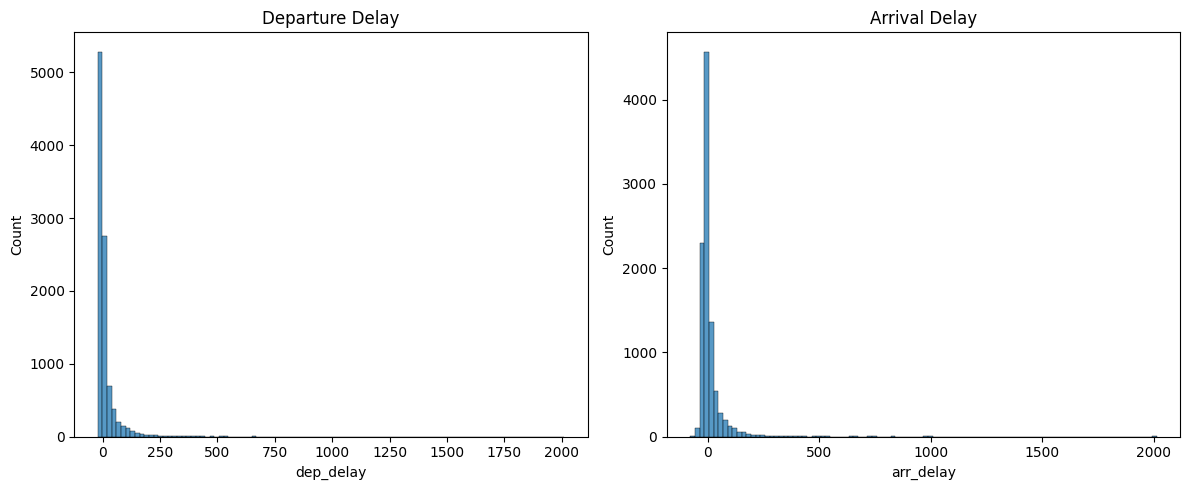

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df["dep_delay"], bins=100, ax=axes[0])
axes[0].set_title("Departure Delay")

sns.histplot(df["arr_delay"], bins=100, ax=axes[1])
axes[1].set_title("Arrival Delay")

plt.tight_layout()
plt.show()


###Varianza

Arrival delay tiene mas varianza en los datos.

In [ ]:
df[["dep_delay","arr_delay"]].var()

,0
dep_delay,2874.548815
arr_delay,3113.999700


###Correlacion de las variables dep_delay y arr_delay


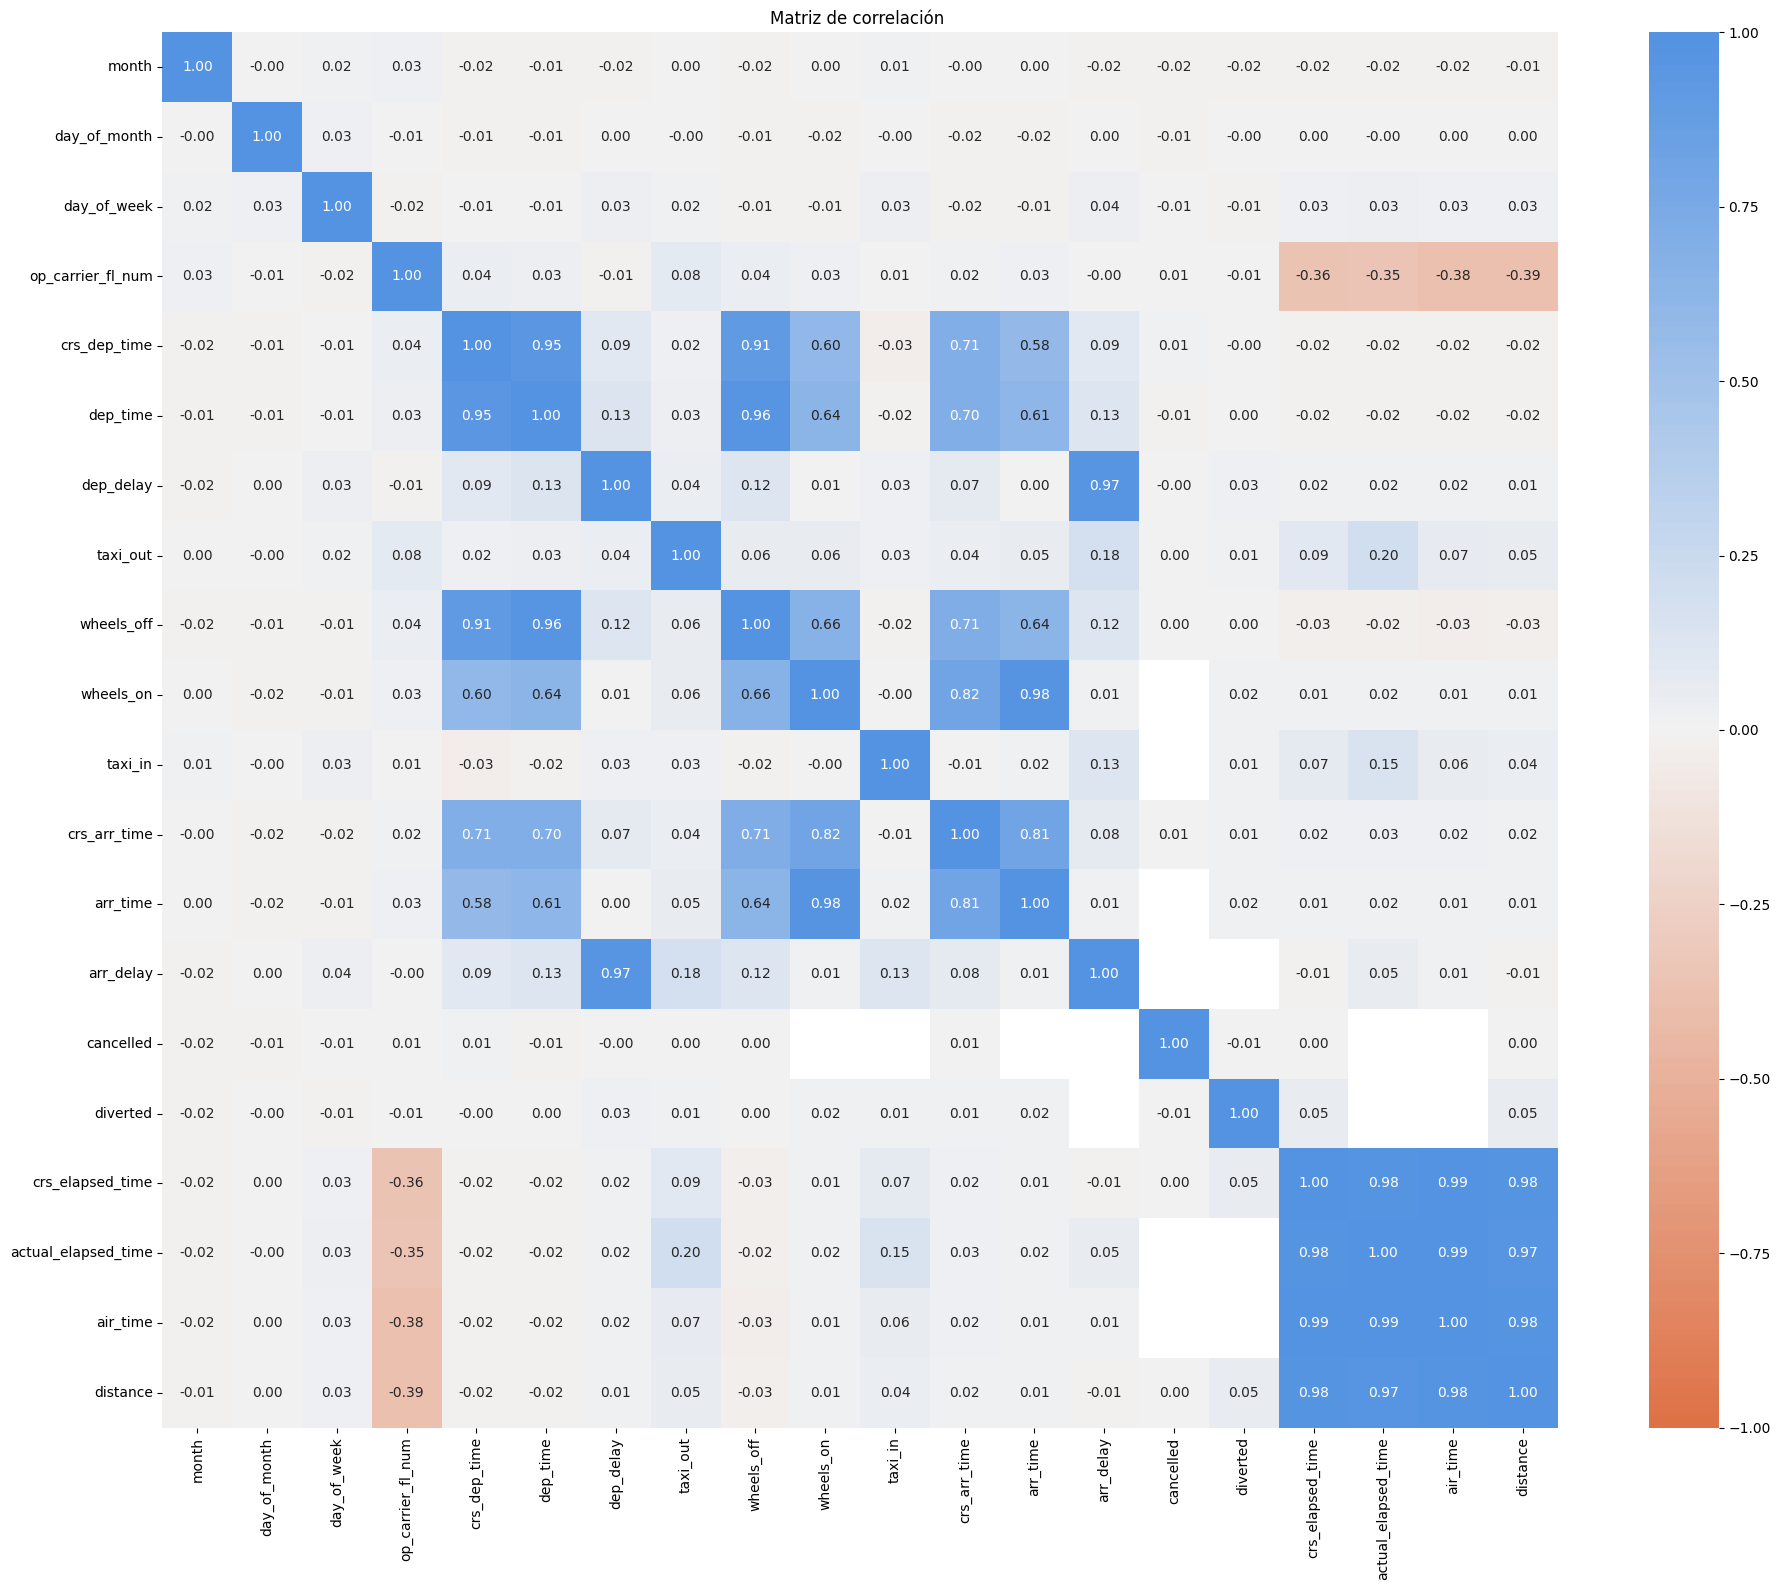

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

predictors = df.select_dtypes(include=["int64", "float64"])
predictors = predictors.drop(columns=["year"])
corr_matrix = predictors.corr()


plt.figure(figsize=(20, 16))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap=sns.diverging_palette(25, 250, s=75, l=60, n=200),
    vmin=-1, vmax=1,
    center=0,
    square=True
)
plt.title("Matriz de correlación ")
plt.tight_layout()
plt.show()

In [ ]:
num_cols = df.select_dtypes(include=["int64","float64"]).columns
print(num_cols)

Index(['year', 'month', 'day_of_month', 'day_of_week', 'op_carrier_fl_num',
       'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
       'cancelled', 'diverted', 'crs_elapsed_time', 'actual_elapsed_time',
       'air_time', 'distance'],
      dtype='object')


In [ ]:
corr = df[num_cols].corr()

corr_dep = corr["dep_delay"].sort_values(ascending=False)
corr_arr = corr["arr_delay"].sort_values(ascending=False)

print("Correlaciones con dep_delay:")
print(corr_dep)

print("\nCorrelaciones con arr_delay:")
print(corr_arr)

Correlaciones con dep_delay:
dep_delay              1.000000
arr_delay              0.966336
dep_time               0.132888
wheels_off             0.120035
crs_dep_time           0.089607
crs_arr_time           0.074131
taxi_out               0.042833
day_of_week            0.031640
diverted               0.027877
taxi_in                0.025466
actual_elapsed_time    0.023171
crs_elapsed_time       0.019571
air_time               0.015582
distance               0.014691
wheels_on              0.005507
arr_time               0.003162
day_of_month           0.002089
cancelled             -0.001457
op_carrier_fl_num     -0.013117
month                 -0.020970
year                        NaN
Name: dep_delay, dtype: float64

Correlaciones con arr_delay:
arr_delay              1.000000
dep_delay              0.966336
taxi_out               0.184382
dep_time               0.130488
taxi_in                0.130079
wheels_off             0.122825
crs_dep_time           0.087433
crs_arr_time 

##Decision de variable objetivo
Se decidio escoger la variable **dep_delay**, debido a que tiene una correlacion semejante a arr_delay, con el resto de los datos y ademas para predecir esta variable se puede hacer con datos que se pueden obtener antes del vuelo, en cambio el arr_delay solo se puede predecir con datos que se consiguen durante el vuelo o al momento del aterrizaje, restando valor en el contexto del negocio.

Ademas se decidio eliminar las variables:

"arr_delay",
"dep_time",
"taxi_out",
"wheels_off",
"wheels_on",
"taxi_in",
"arr_time" ,
"actual_elapsed_time",
"air_time",
"cancelled",
"cancellation_code",
"diverted",
"origin_city_name",
"dest_city_name",
"diverted"


Se borran debido a que son variables que solo se pueden conseguir durante el vuelo o en el aterrizaje, ademas variables como "cancelled" y "cancellation_code" se borran porque no presentan ningun sentido para la prediccion.

In [ ]:
df = df.drop(["arr_delay", "dep_time", "taxi_out", "wheels_off", "wheels_on", "taxi_in", "arr_time" , "actual_elapsed_time", "air_time", "cancelled", "cancellation_code", "diverted", "origin_city_name", "dest_city_name", "fl_date"], axis=1)

In [ ]:
print("Shape:" ,df.shape, "\n")
df.info(verbose=True)

Shape: (10000, 15) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               10000 non-null  int64  
 1   month              10000 non-null  int64  
 2   day_of_month       10000 non-null  int64  
 3   day_of_week        10000 non-null  int64  
 4   op_unique_carrier  10000 non-null  object 
 5   op_carrier_fl_num  10000 non-null  float64
 6   origin             10000 non-null  object 
 7   origin_state_nm    10000 non-null  object 
 8   dest               10000 non-null  object 
 9   dest_state_nm      10000 non-null  object 
 10  crs_dep_time       10000 non-null  int64  
 11  dep_delay          9884 non-null   float64
 12  crs_arr_time       10000 non-null  int64  
 13  crs_elapsed_time   10000 non-null  float64
 14  distance           10000 non-null  float64
dtypes: float64(4), int64(6), object(5)
memory usage: 1

##Eliminacion de muestras sin variable objetivo

Se decide eliminar las muestras del sample que no tienen variable objetivo, son 116 muestras, para quedar con un sample final de 9884.

Esta decicion se tomo debido a que no es buena idea utilizar tecnicas de relleno con la variable objetivo, esto para no iducir un sesgo ni modificar el patron real de las muestras al utilizar el promedio, para rellenar los datos faltantes.


**Muestras sin variable objetivo**

In [ ]:
df[df["dep_delay"].isna()]

,year,month,day_of_month,day_of_week,op_unique_carrier,op_carrier_fl_num,origin,origin_state_nm,dest,dest_state_nm,crs_dep_time,dep_delay,crs_arr_time,crs_elapsed_time,distance
24,2024,1,16,2,AA,2100.0,DFW,Texas,MCI,Missouri,1538,NaN,1710,92.0,460.0
122,2024,7,20,6,9E,4806.0,CHO,Virginia,ATL,Georgia,1820,NaN,2005,105.0,457.0
200,2024,1,12,5,AS,292.0,SFO,California,EWR,New Jersey,805,NaN,1640,335.0,2565.0
264,2024,2,1,4,WN,1981.0,DAL,Texas,LAS,Nevada,1750,NaN,1850,180.0,1067.0
333,2024,5,28,2,AA,2745.0,DFW,Texas,DCA,Virginia,1505,NaN,1859,174.0,1192.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9553,2024,10,9,3,WN,2475.0,MHT,New Hampshire,MCO,Florida,1455,NaN,1810,195.0,1142.0
9727,2024,7,22,1,DL,2717.0,SAT,Texas,MSP,Minnesota,633,NaN,930,177.0,1097.0
9906,2024,1,7,7,UA,2465.0,EWR,New Jersey,MIA,Florida,715,NaN,1023,188.0,1085.0
9923,2024,7,20,6,9E,5220.0,MSP,Minnesota,OMA,Nebraska,1515,NaN,1634,79.0,282.0


In [ ]:
df = df[df["dep_delay"].notna()]

In [ ]:
df

,year,month,day_of_month,day_of_week,op_unique_carrier,op_carrier_fl_num,origin,origin_state_nm,dest,dest_state_nm,crs_dep_time,dep_delay,crs_arr_time,crs_elapsed_time,distance
0,2024,4,18,4,MQ,3535.0,DFW,Texas,RAP,South Dakota,1018,-3.0,1149,151.0,835.0
1,2024,1,1,1,AA,148.0,CLT,North Carolina,PHX,Arizona,1637,-4.0,1923,286.0,1773.0
2,2024,12,12,4,9E,5440.0,CHA,Tennessee,ATL,Georgia,1000,-8.0,1059,59.0,106.0
3,2024,4,8,1,WN,1971.0,OMA,Nebraska,LAS,Nevada,1330,4.0,1430,180.0,1099.0
4,2024,2,16,5,WN,862.0,BWI,Maryland,MYR,South Carolina,1340,-7.0,1510,90.0,399.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2024,1,16,2,WN,3692.0,KOA,Hawaii,OGG,Hawaii,1420,0.0,1500,40.0,84.0
9996,2024,7,5,5,AA,1924.0,LAS,Nevada,ORD,Illinois,1005,-3.0,1551,226.0,1514.0
9997,2024,2,28,3,MQ,3418.0,AUS,Texas,ORD,Illinois,1505,2.0,1742,157.0,977.0
9998,2024,2,18,7,DL,1117.0,ATL,Georgia,OKC,Oklahoma,1745,-7.0,1905,140.0,761.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9884 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               9884 non-null   int64  
 1   month              9884 non-null   int64  
 2   day_of_month       9884 non-null   int64  
 3   day_of_week        9884 non-null   int64  
 4   op_unique_carrier  9884 non-null   object 
 5   op_carrier_fl_num  9884 non-null   float64
 6   origin             9884 non-null   object 
 7   origin_state_nm    9884 non-null   object 
 8   dest               9884 non-null   object 
 9   dest_state_nm      9884 non-null   object 
 10  crs_dep_time       9884 non-null   int64  
 11  dep_delay          9884 non-null   float64
 12  crs_arr_time       9884 non-null   int64  
 13  crs_elapsed_time   9884 non-null   float64
 14  distance           9884 non-null   float64
dtypes: float64(4), int64(6), object(5)
memory usage: 1.2+ MB


##Preparacion de las variables para los modelos

**y** = variable objetivo

**x** = resto de variables

In [ ]:
y = df["dep_delay"]

X = df.drop(columns=["dep_delay"])

##One hot encoding de las variables categoricas y escalado numerico

Se realiza el proceso de escalado numerico porque para los modelos que vamos usar, las variables deben de ser similares en escala, esto para que no haya problemas en el proceso de optimizacion.


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [ ]:
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False), cat_cols),
        ("num", StandardScaler(), num_cols),
    ]
)

#4.Entrenamiento y evaluacion de los modelos

Los modelos seleccionados fueron: RandomForestRegressor, LinearRegression, SVR,
KNeighborsRegressor y MLPRegressor

In [ ]:

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [ ]:


models = {
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "LinearRegression": LinearRegression(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "MLP": MLPRegressor(max_iter=500, random_state=42),
}

param_grids = {
    "RandomForest": {
        "model__n_estimators": [100, 300],
        "model__max_depth": [None, 10, 20],
        "model__min_samples_split": [2, 5],
    },
    "LinearRegression": {
        "model__fit_intercept": [True, False],
        "model__positive": [False, True],
    },
    "SVR": {
        "model__kernel": ["rbf"],
        "model__C": [1, 10],
        "model__gamma": ["scale", "auto"],
        "model__epsilon": [0.1, 1.0],
    },
    "KNN": {
        "model__n_neighbors": [3, 5, 11],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2],
    },
    "MLP": {
        "model__hidden_layer_sizes": [(50,), (100,)],
        "model__activation": ["relu", "tanh"],
        "model__alpha": [1e-4, 1e-3],
    },
}


El metodo de validacion que seleccionamos es el Kfold cross validation con 5 splits

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

resultados = {}
detalles_todos = []

for name, model in models.items():
    print(f"\n===== Modelo: {name} =====")

    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model),
    ])

    param_grid = param_grids[name]

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=cv,
        n_jobs=-1,
        verbose=0,
        return_train_score=False,
    )

    grid.fit(X_train, y_train)


    res = pd.DataFrame(grid.cv_results_)
    res["modelo"] = name
    res["mean_MAE"] = -res["mean_test_score"]
    res["std_MAE"]  = res["std_test_score"]

    res = res.sort_values("rank_test_score")

    detalles_todos.append(res)

    print("Mejores hiperparámetros (CV):", grid.best_params_)
    print("Mejor MAE (CV):", -grid.best_score_)


    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    mae_test = mean_absolute_error(y_test, y_pred)
    mse_test = mean_squared_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    print("MAE en test :", mae_test)
    print("RMSE en test:", mse_test)
    print("R² en test  :", r2_test)

    resultados[name] = {
        "best_params": grid.best_params_,
        "mae_cv": -grid.best_score_,
        "mae_test": mae_test,
        "rmse_test": mse_test,
        "r2_test": r2_test,
    }

df_detalles = pd.concat(detalles_todos, ignore_index=True)


cols_param = [c for c in df_detalles.columns if c.startswith("param_")]
cols_to_show = ["modelo", "mean_MAE", "std_MAE", "rank_test_score"] + cols_param

df_detalles_mostrar = df_detalles[cols_to_show].sort_values(
    ["modelo", "rank_test_score"]
)

print("\n\n===== DATASET DE TODOS LOS HIPERPARÁMETROS Y RESULTADOS (CV) =====")
print(df_detalles_mostrar)



===== Modelo: RandomForest =====


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros (CV): {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Mejor MAE (CV): 25.031102414785558
MAE en test : 24.751616787263696
RMSE en test: 2749.057716044483
R² en test  : -0.1409927606369672

===== Modelo: LinearRegression =====


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Mejores hiperparámetros (CV): {'model__fit_intercept': False, 'model__positive': True}
Mejor MAE (CV): 26.04438536629479
MAE en test : 24.70574101204015
RMSE en test: 2472.5883503612586
R² en test  : -0.02624451692372065

===== Modelo: SVR =====


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Mejores hiperparámetros (CV): {'model__C': 1, 'model__epsilon': 1.0, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Mejor MAE (CV): 19.166636479477763


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE en test : 18.213928389111107
RMSE en test: 2574.859923632536
R² en test  : -0.06869219782922831

===== Modelo: KNN =====
Mejores hiperparámetros (CV): {'model__n_neighbors': 11, 'model__p': 1, 'model__weights': 'uniform'}
Mejor MAE (CV): 25.840804167928816


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE en test : 24.79748930887019
RMSE en test: 2537.6009606340685
R² en test  : -0.05322791463067067

===== Modelo: MLP =====
Mejores hiperparámetros (CV): {'model__activation': 'tanh', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (50,)}
Mejor MAE (CV): 34.356544125257855
MAE en test : 34.179631021793746
RMSE en test: 3244.273216124169
R² en test  : -0.34653129744118827


===== DATASET DE TODOS LOS HIPERPARÁMETROS Y RESULTADOS (CV) =====
              modelo      mean_MAE       std_MAE  rank_test_score  \
24               KNN  2.584080e+01  4.726795e-01                1   
25               KNN  2.587960e+01  4.269268e-01                2   
26               KNN  2.601227e+01  4.283755e-01                3   
27               KNN  2.602614e+01  3.933406e-01                4   
28               KNN  2.675361e+01  5.544567e-01                5   
29               KNN  2.684349e+01  4.934967e-01                6   
30               KNN  2.712753e+01  4.925134e-01                7   


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


###Tabla GridSearch de los modelos

In [ ]:
df_detalles_mostrar

,modelo,mean_MAE,std_MAE,rank_test_score,param_model__max_depth,param_model__min_samples_split,param_model__n_estimators,param_model__fit_intercept,param_model__positive,param_model__C,param_model__epsilon,param_model__gamma,param_model__kernel,param_model__n_neighbors,param_model__p,param_model__weights,param_model__activation,param_model__alpha,param_model__hidden_layer_sizes
24,KNN,2.584080e+01,4.726795e-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1.0,uniform,NaN,NaN,NaN
25,KNN,2.587960e+01,4.269268e-01,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1.0,distance,NaN,NaN,NaN
26,KNN,2.601227e+01,4.283755e-01,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.0,uniform,NaN,NaN,NaN
27,KNN,2.602614e+01,3.933406e-01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.0,distance,NaN,NaN,NaN
28,KNN,2.675361e+01,5.544567e-01,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1.0,uniform,NaN,NaN,NaN
29,KNN,2.684349e+01,4.934967e-01,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1.0,distance,NaN,NaN,NaN
30,KNN,2.712753e+01,4.925134e-01,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,uniform,NaN,NaN,NaN
31,KNN,2.715827e+01,4.545871e-01,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,distance,NaN,NaN,NaN
32,KNN,2.766339e+01,4.182451e-01,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,uniform,NaN,NaN,NaN
33,KNN,2.779009e+01,4.132496e-01,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,distance,NaN,NaN,NaN


#5.Reduccion de dimension

##Matriz de correlacion de la variables

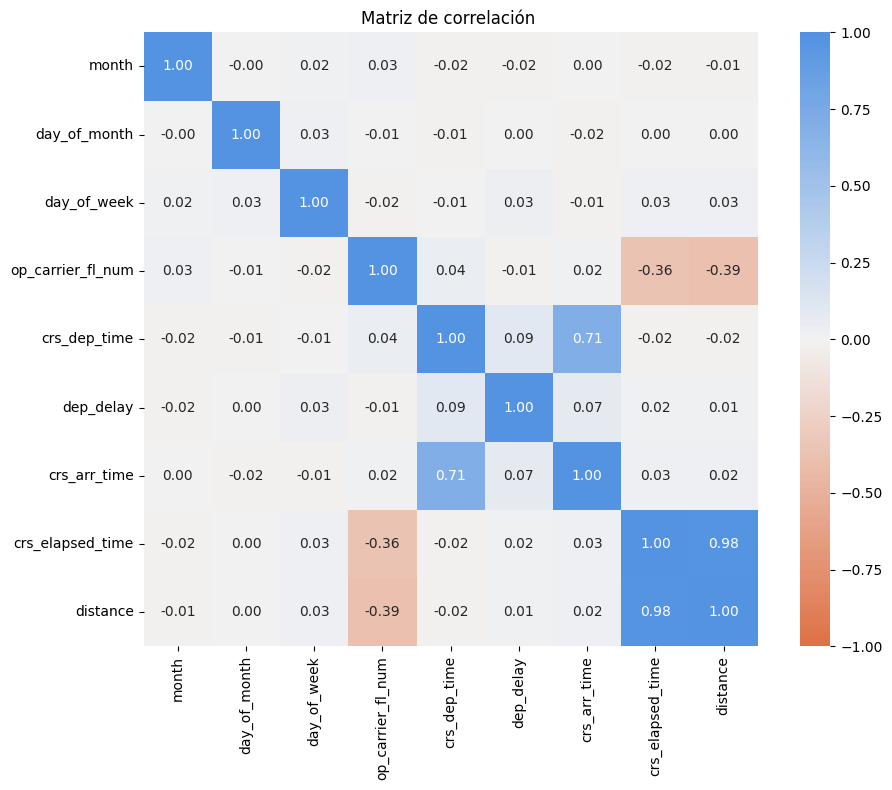

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

predictors = df.select_dtypes(include=["int64", "float64"])
predictors = predictors.drop(columns=["year"])
corr_matrix = predictors.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap=sns.diverging_palette(25, 250, s=75, l=60, n=200),
    vmin=-1, vmax=1,
    center=0,
    square=True
)
plt.title("Matriz de correlación ")
plt.tight_layout()
plt.show()


##PCA
Como criterio de eleccion del numero de componentes, utilizamos el porcentaje de varianza acumulada, en este caso el numero de cimponentes que conserva el 95% de la varianza acumulada.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
X_transformed = preprocess.fit_transform(X)
print("Numero de componentes original: ", X_transformed.shape)

Numero de componentes original:  (9884, 694)


In [ ]:
svr_best = SVR(
    C=1.0,
    epsilon=1,
    gamma="scale",
    kernel="rbf"
)

pipe_pca_svr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("pca", PCA(n_components=0.95)),
    ("model", svr_best),
])

pipe_pca_svr.fit(X_train, y_train)

n_components_used = pipe_pca_svr.named_steps["pca"].n_components_
print("Number of PCA components used:", n_components_used)


y_pred = pipe_pca_svr.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2   = r2_score(y_test, y_pred)

print("MAE  :", mae)
print("RMSE :", rmse)
print("R²   :", r2)

Number of PCA components used: 113


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE  : 18.20561380038647
RMSE : 50.73239528841706
R²   : -0.06824228841475377


In [ ]:
svr_best2 = SVR(
    C=1.0,
    epsilon=0.1,
    gamma="scale",
    kernel="rbf"
)

pipe_pca_svr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("pca", PCA(n_components=0.95)),
    ("model", svr_best2),
])

pipe_pca_svr.fit(X_train, y_train)

n_components_used = pipe_pca_svr.named_steps["pca"].n_components_
print("Number of PCA components used:", n_components_used)

y_pred = pipe_pca_svr.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2   = r2_score(y_test, y_pred)

print("MAE  :", mae)
print("RMSE :", rmse)
print("R²   :", r2)

Number of PCA components used: 113


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE  : 18.209171186130575
RMSE : 50.76131205596804
R²   : -0.06946040229392692


##UMAP

In [ ]:
import umap.umap_ as umap

In [ ]:
# Número de variables originales (las columnas de X ANTES de UMAP)
p_original = X_train.shape[1]
print("Número de variables originales:", p_original)

# Lista de números de componentes que quieres probar con UMAP
n_components_list = [113]   # puedes ajustarla

def eval_umap_svr(model, model_name, n_components_list):
    filas = []

    for n_comp in n_components_list:
        # UMAP para reducir a n_comp dimensiones
        umap_reducer = umap.UMAP(
            n_components=n_comp,
            n_neighbors=15,
            min_dist=0.1,
            random_state=42
        )

        # Pipeline: preprocess -> UMAP -> SVR
        pipe = Pipeline(steps=[
            ("preprocess", preprocess),   # ya definido antes
            ("umap", umap_reducer),
            ("model", model),
        ])

        # Entrenar y evaluar en test
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        mae  = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred) ** 0.5
        r2   = r2_score(y_test, y_pred)

        reduccion = 100 * (1 - n_comp / p_original)

        filas.append({
            "modelo": model_name,
            "n_components": n_comp,
            "%_reduccion": reduccion,
            "MAE_test": mae,
            "RMSE_test": rmse,
            "R2_test": r2
        })

    return pd.DataFrame(filas)


# Evaluar los dos SVR
tabla_svr_eps1   = eval_umap_svr(svr_best,  "SVR_eps_1.0",   n_components_list)
tabla_svr_eps01  = eval_umap_svr(svr_best2, "SVR_eps_0.1",   n_components_list)

# Unir todo en una sola tabla
tabla_umap = pd.concat([tabla_svr_eps1, tabla_svr_eps01], ignore_index=True)

print(tabla_umap)


Número de variables originales: 14


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


        modelo  n_components  %_reduccion   MAE_test  RMSE_test   R2_test
0  SVR_eps_1.0           113  -707.142857  18.466181  50.958069 -0.077767
1  SVR_eps_0.1           113  -707.142857  18.458989  50.991767 -0.079193


In [ ]:
# Transform training data with preprocess only
X_train_pre = preprocess.fit_transform(X_train)

In [ ]:
umap_2d = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)

X_train_umap2 = umap_2d.fit_transform(X_train_pre)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


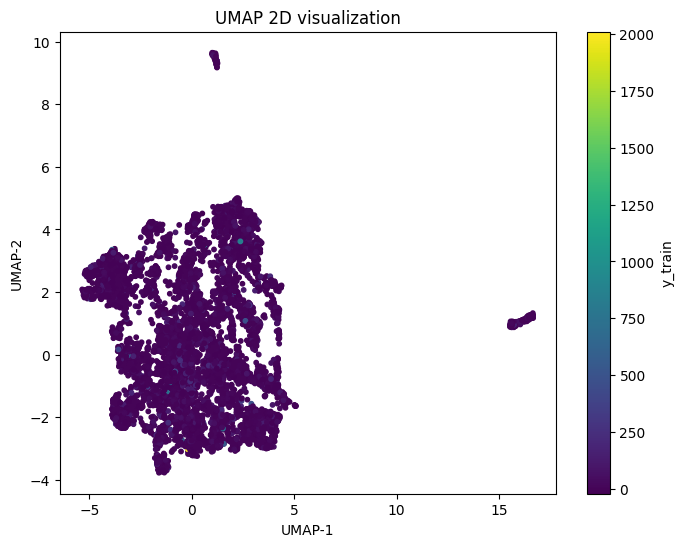

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(
    X_train_umap2[:,0],
    X_train_umap2[:,1],
    c=y_train,
    cmap="viridis",
    s=10
)
plt.colorbar(label="y_train")
plt.title("UMAP 2D visualization")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


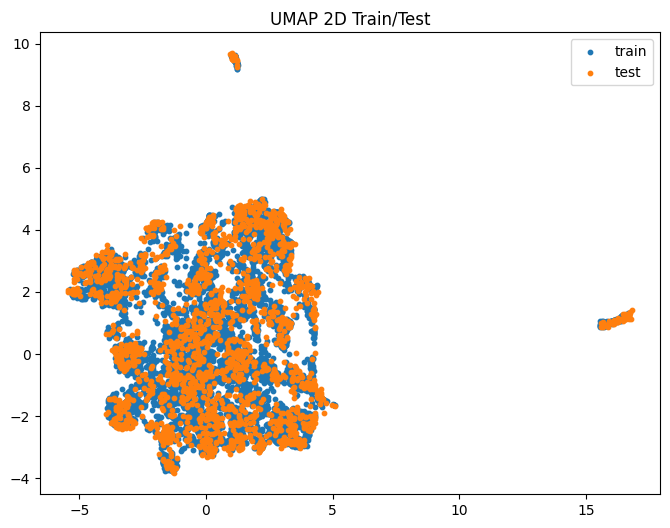

In [ ]:
X_test_pre = preprocess.transform(X_test)
X_test_umap2 = umap_2d.transform(X_test_pre)

plt.figure(figsize=(8,6))
plt.scatter(X_train_umap2[:,0], X_train_umap2[:,1], s=10, label="train")
plt.scatter(X_test_umap2[:,0], X_test_umap2[:,1], s=10, label="test")
plt.legend()
plt.title("UMAP 2D Train/Test")
plt.show()